## Visualising variation in space and time (Hovmoller plot)

This notebook describes how to generate a space-time (Hovmoller plot) visualisation of NDVI, the example shown here is for the Mitchell River in Queensland.  The river channel migrates, and a Hovmoller plot generated from a transect that crosses the river shows the channel migration and associated vegetation changes.

In [6]:
%pylab notebook
from __future__ import print_function
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


In [7]:
dc = datacube.Datacube(app='linear extraction for Hovmoller plot')

In [8]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords


#Define temporal range
start_of_epoch = '1998-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls8', 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch)}
lat_max = -15.94
lat_min = -15.98
lon_max = 142.49522
lon_min = 142.4485

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [9]:
print(query)

{'time': ('1998-01-01', '2016-12-31'), 'crs': 'EPSG:4326', 'y': (-15.94, -15.98), 'x': (142.4485, 142.49522)}


# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [10]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [11]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day',  **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [12]:
#Conctanate measurements from the different sensors together
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine
#calculate the normalised difference vegetation index  (NDVI)
all_ndvi_sorted = ((nbar_clean.nir - nbar_clean.red)/(nbar_clean.nir + nbar_clean.red))

In [13]:
print('The number of time slices at this location is '+ str(nbar_clean.red.shape[0]))

The number of time slices at this location is 578


## Plotting an image, select a location for extracting the hovmoller plot
The interactive widget allows you to select a location (x, y coordinates), the plot will then show all of the time series that fall into the same x coordinate.

In [14]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 481
rgb = nbar_clean.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20170221/envs/agdc/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


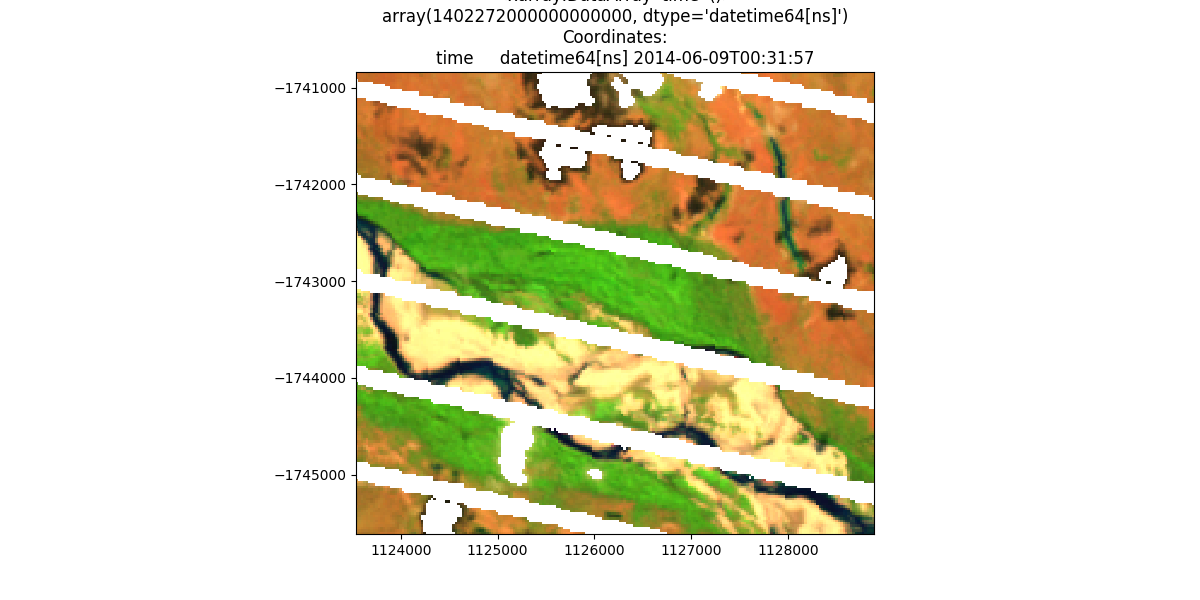

In [16]:
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbar_clean.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [17]:
#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])


#This sets up the NDVI colour ramp and corresponding thresholds
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

<IPython.core.display.Javascript object>


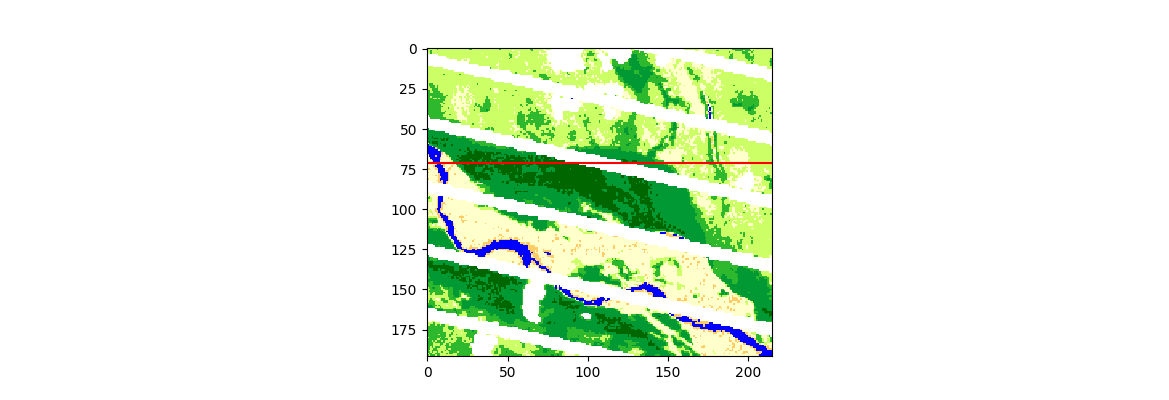

In [19]:
#This cell shows the x transect that you've chosen in the context of an NDVI image with a suitable colour ramp
fig = plt.figure(figsize=(11.69,4))
plt.plot([0, all_ndvi_sorted.shape[2]], [imagey,imagey], 'r')
plt.imshow(all_ndvi_sorted.isel(time = time_slice_i), cmap = ndvi_cmap, norm = ndvi_norm)


<IPython.core.display.Javascript object>


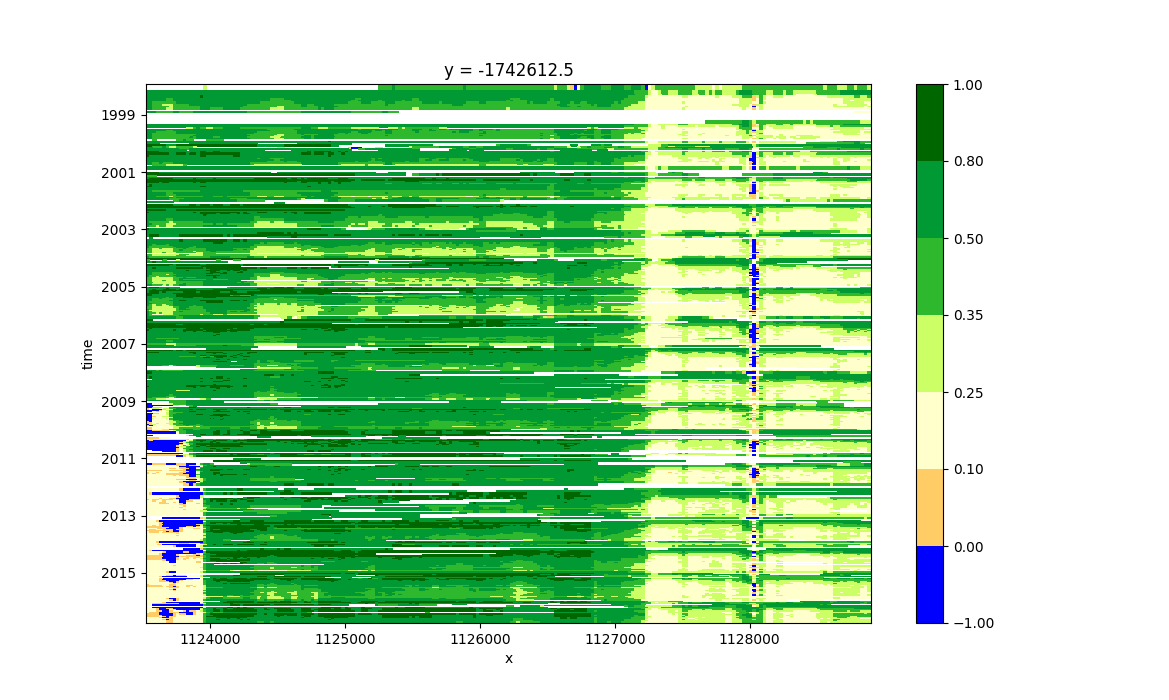

In [20]:
#Hovmoller plot for the x transect
fig = plt.figure(figsize=(11.69,7))
all_ndvi_sorted.isel(#x=[xdim],
                     y=[imagey]
                     ).plot(norm= ndvi_norm, cmap = ndvi_cmap, yincrease = False)